In [1]:
import sys
sys.path += ["../"]

import smbh
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import curve_fit

from astropy.cosmology import FlatLambdaCDM#LambdaCDM
COLOR_CYCLE = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Cosmology

In [2]:
cosmo = FlatLambdaCDM(H0 = 67.8, Om0 = 0.309)

# Results

In [3]:
symmetric = np.genfromtxt("results.txt", skip_header = 1)

return_times = np.genfromtxt('../Week 13/return_times.txt')
return_masses = np.genfromtxt('../Week 13/return_masses.txt')
lyapunov = np.genfromtxt("../Week 13/lyapunov_exponents.txt")

# Global distributions

In [4]:
def gaussian(x, mu, std):
    v = std ** 2
    f = 1 / (2 * np.pi * v) ** 0.5
    exp = np.exp(- (x - mu) ** 2 / (2 * v))
    return f * exp

def plotHistogram(data, log = False, int_ = None, bins = 500, density = True, ax = None, figsize = (8, 4.5),*args, **kwargs):
    if ax == None:
        fig, ax = plt.subplots(figsize = figsize)
    if log:
        freq, bins = np.histogram(np.log10(data), bins = bins, density = density)
        bins = 10 ** bins
        db = np.diff(bins)
        bins = 0.5 * (bins[1:] + bins[:-1])
        freq = freq / np.trapz(freq, np.log10(bins))
    else:
        freq, bins = np.histogram(data, bins = bins, density = density)
        db = np.diff(bins)
        bins = 0.5 * (bins[1:] + bins[:-1])
        freq = freq / np.trapz(freq, bins)

    if int_ != None:
        freq = freq / int_
        
    ax.bar(bins, freq, width = db, *args, **kwargs)
    return ax, (bins, freq)

## Masses

In [5]:
m_max = 4
masses = return_masses.flatten()
pos = (masses > 1) & (masses < m_max)

masses = masses[pos]

mu1 = masses.mean()
std1 = masses.std()

mu2 = symmetric[:, 1].mean()
std2 = symmetric[:, 1].std()

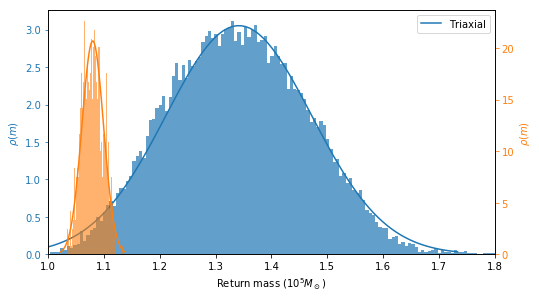

In [6]:
x1 = 3 * np.linspace(-std1, std1, 100) + mu1
x2 = 3 * np.linspace(-std2, std2, 100) + mu2
y1 = gaussian(x1, mu1, std1)
y2 = gaussian(x2, mu2, std2)

fig, ax1 = plt.subplots(figsize = (8, 4.5))

ax2 = ax1.twinx()

plotHistogram(masses, ax = ax1, alpha = 0.7)
ax1.plot(x1, y1)

plotHistogram(symmetric[:, 1], bins = 100, ax = ax2, alpha = 0.6, facecolor = COLOR_CYCLE[1])
ax2.plot(x2, y2, c = COLOR_CYCLE[1])

ax1.set_xlabel('Return mass ($10 ^ 5M_\odot$)')
ax1.set_ylabel(r'$\rho(m)$', color = COLOR_CYCLE[0])
ax1.tick_params('y', colors = COLOR_CYCLE[0])
ax2.set_ylabel(r'$\rho(m)$', color = COLOR_CYCLE[1])
ax2.tick_params('y', colors = COLOR_CYCLE[1])

ax1.set_xlim(1, 1.8)

ax1.legend(['Triaxial'])
# ax2.legend(['Spherical'])

fig.savefig('dist_masses.png', dpi = 300)

plt.show()

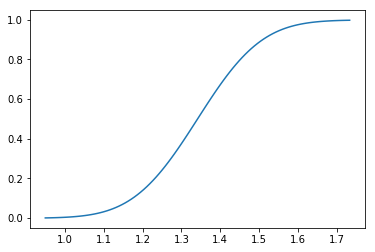

In [7]:
cumulative = [np.trapz(y1[:i + 1], x = x1[: i + 1]) for i in range(len(y1))]
plt.plot(x1, cumulative)

## Times

In [8]:
def function(x, mu1, std1, mu2, std2, a, b):
    return a * gaussian(np.log10(x), mu1, std1) + gaussian(np.log10(x), mu2, std2) * b

[1.35844807 0.27346986 2.22550583 0.81468827 0.2381185  0.91140796]


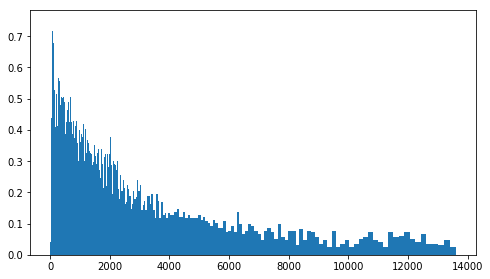

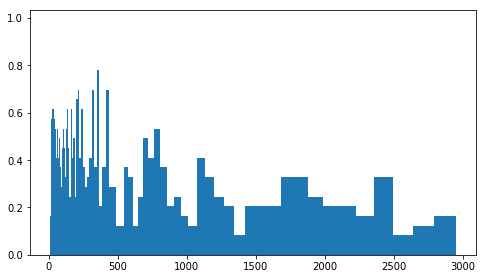

In [39]:
times = return_times.flatten()
pos = times != times.max()

times = 1000 * times[pos]

_, (bins, freq) = plotHistogram(times, log = True)
_, (bins2, freq2) = plotHistogram(1000 * symmetric[:, 0], log = True, bins = 100)

popt, pcov = curve_fit(function, bins, freq, bounds = (([-np.inf] * 4 + [0] * 2), ([np.inf] * 4 + [1] * 2)))
mu1, std1, mu2, std2, a, b = popt

popt2, pcov2 = curve_fit(function, bins2, freq2, bounds = (([-np.inf] * 4 + [0] * 2), ([np.inf] * 4 + [1] * 2)))
mu12, std12, mu22, std22, a2, b2 = popt2
print(popt2)

x = np.logspace(0, 6, 500)
y = function(x, *popt)
y2 = function(x, *popt2)

int_ = np.trapz(y, x = x)
int_2 = np.trapz(y2, x = x)

popt[-2:] *= 1 / int_
popt2[-2:] *= 1 / int_2

y = y / int_
y2 = y2 / int_2

mu2, std2, mu1, std1, b, a = popt

In [34]:
print('mu1: %f\nstd1: %f\nmu2: %f\nstd2: %f\na: %f\nb: %f' % tuple(popt) )

mu1: 2.593323
std1: 0.635890
mu2: 1.821194
std2: 0.237004
a: 0.000371
b: 0.000123


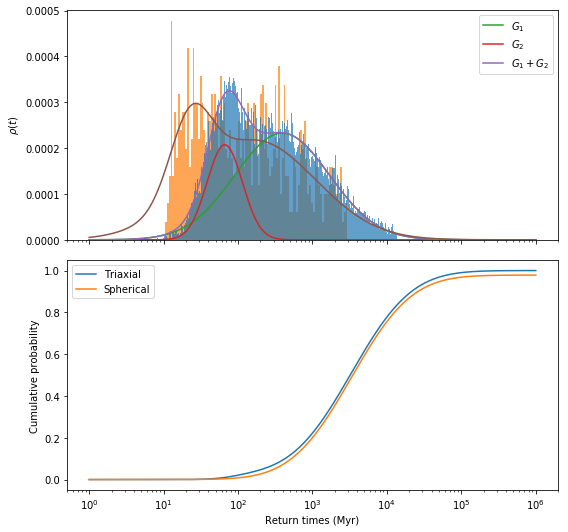

In [49]:
fig, (ax1, ax2) = plt.subplots(2, figsize = (8, 7.5), sharex = True)

plotHistogram(1000 * symmetric[:, 0], log = True, int_ = int_2, ax = ax1, bins = 100, alpha = 0.7, facecolor = COLOR_CYCLE[1])
plotHistogram(times, log = True, int_ = int_, ax = ax1, alpha = 0.7, facecolor = COLOR_CYCLE[0])

y1 = a * gaussian(np.log10(x), mu1, std1)
y2 = b * gaussian(np.log10(x), mu2, std2)

ax1.plot(x, y2, c = COLOR_CYCLE[2], label = '$G_1$')
ax1.plot(x, y1, c = COLOR_CYCLE[3], label= '$G_2$')
ax1.plot(x, y, c = COLOR_CYCLE[4], label = '$G_1 + G_2$')
ax1.plot(x, function(x, *popt2), c = COLOR_CYCLE[5])

ax1.set_ylabel(r'$\rho(t)$')

ax2.set_xlabel(r'Return times (Myr)')
ax2.set_ylabel(r'Cumulative probability')

ax1.legend()

cumulative = [np.trapz(y[: i + 1], x = x[: i + 1]) for i in range(len(y))]
ax2.plot(x, cumulative, label = 'Triaxial')

cumulative2 = [np.trapz(y2[: i + 1], x = x[: i + 1]) for i in range(len(y2))]
ax2.plot(x, cumulative2, label = 'Spherical')
ax1.set_xscale("log")
ax2.legend()

fig.tight_layout()
fig.savefig('dist_times.png', dpi = 300)
plt.show()

In [42]:
def requiredTforMass(m, m0, e = 0.1, t_edd = 0.44):
    return (e * t_edd) / (1 - e) * np.log(m / m0)

In [43]:
t_20 = cosmo.age(20).value * 1000
t_7 = cosmo.age(7.54).value * 1000

t_window = t_7 - t_20
t_required = requiredTforMass(8e8, 1e5) * 1000
t_available = t_window - t_required

In [44]:
t_available, np.log10(t_available)

(73.53245011240477, 1.866479036970921)

1.2333751852859012 1.6811193681052734


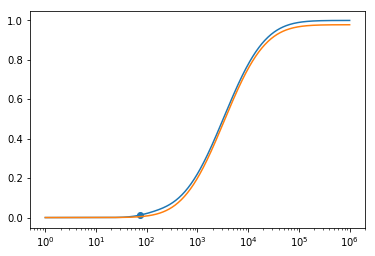

In [51]:
x_ = np.logspace(0, np.log10(t_available))
y_ = function(x_, *popt)
y_2 = function(x_, *popt2)

probability = np.trapz(y_, x_)
probability_2 = np.trapz(y_2, x_)

print(probability * 100, probability_2 * 100)

plt.plot(x, cumulative)
plt.plot(x, cumulative2)
plt.scatter(t_available, probability)
# plt.scatter(t_available, probability_2)
plt.xscale("log")

In [52]:
zs = np.linspace(8, 0)
ts = cosmo.age(zs).value * 1000 - t_20 - t_required

y_ = function(ts, *popt)
y_2 = function(ts, *popt2)

# SDSS (Sloan Digital Sky Survey)

In [53]:
# with fits.open("DR14Q_v4_4.fits") as file:
#     data = file[1].data
#     zs = data['Z']
# np.savetxt('redshifts.txt', zs)
zs = np.genfromtxt('redshifts.txt')

In [54]:
freq, bins = np.histogram(zs, bins = int(5e2))
db = np.diff(bins)
bins = 0.5 * (bins[1:] + bins[:-1])

In [57]:
ts = cosmo.age(bins).value * 1000 - t_20 - t_required
# p = function(ts, *popt)
p = np.array([quad(function, ts[i + 1], ts[i], args = tuple(popt))[0] for i in range(len(ts) - 1)])
p2 = np.array([quad(function, ts[i + 1], ts[i], args = tuple(popt2))[0] for i in range(len(ts) - 1)])

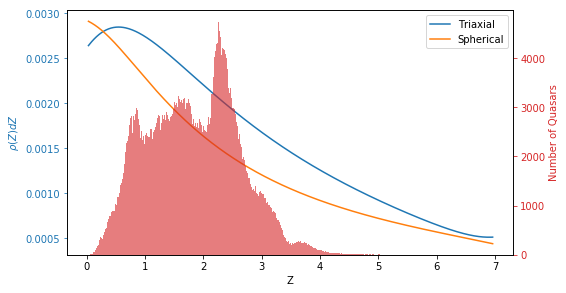

In [63]:
fig, ax1 = plt.subplots(figsize = (8, 4.5))
ax2 = ax1.twinx()

ax1.plot(bins[1:], p, c = COLOR_CYCLE[0], label = 'Triaxial')
ax1.plot(bins[1:], p2, c = COLOR_CYCLE[1], label = 'Spherical')
ax2.bar(bins, freq, width = db, facecolor = COLOR_CYCLE[3], alpha = 0.6)

ax1.set_xlabel('Z')
ax1.set_ylabel(r'$\rho(Z)dZ$', color = COLOR_CYCLE[0])
ax1.tick_params('y', colors = COLOR_CYCLE[0])
ax2.set_ylabel('Number of Quasars', color = COLOR_CYCLE[3])
ax2.tick_params('y', colors = COLOR_CYCLE[3])

ax1.legend()

fig.savefig('redshift_dist.png', dpi = 300)